In [1]:
# imports
import numpy as np
import soundfile as sf
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import Audio

# data
my_tones = [28, 70, 93]

# constants
midi_low = 24
midi_high = 108

# load midi frequencies
file = open('midi.txt', 'r').readlines()
midi_freqs = [0 for i in range(0, midi_high + 1)]
for line in file:
    line = line.split()
    midi_freqs[int(line[0])] = float(line[1])


In [2]:
# ----------- part 1 -------------

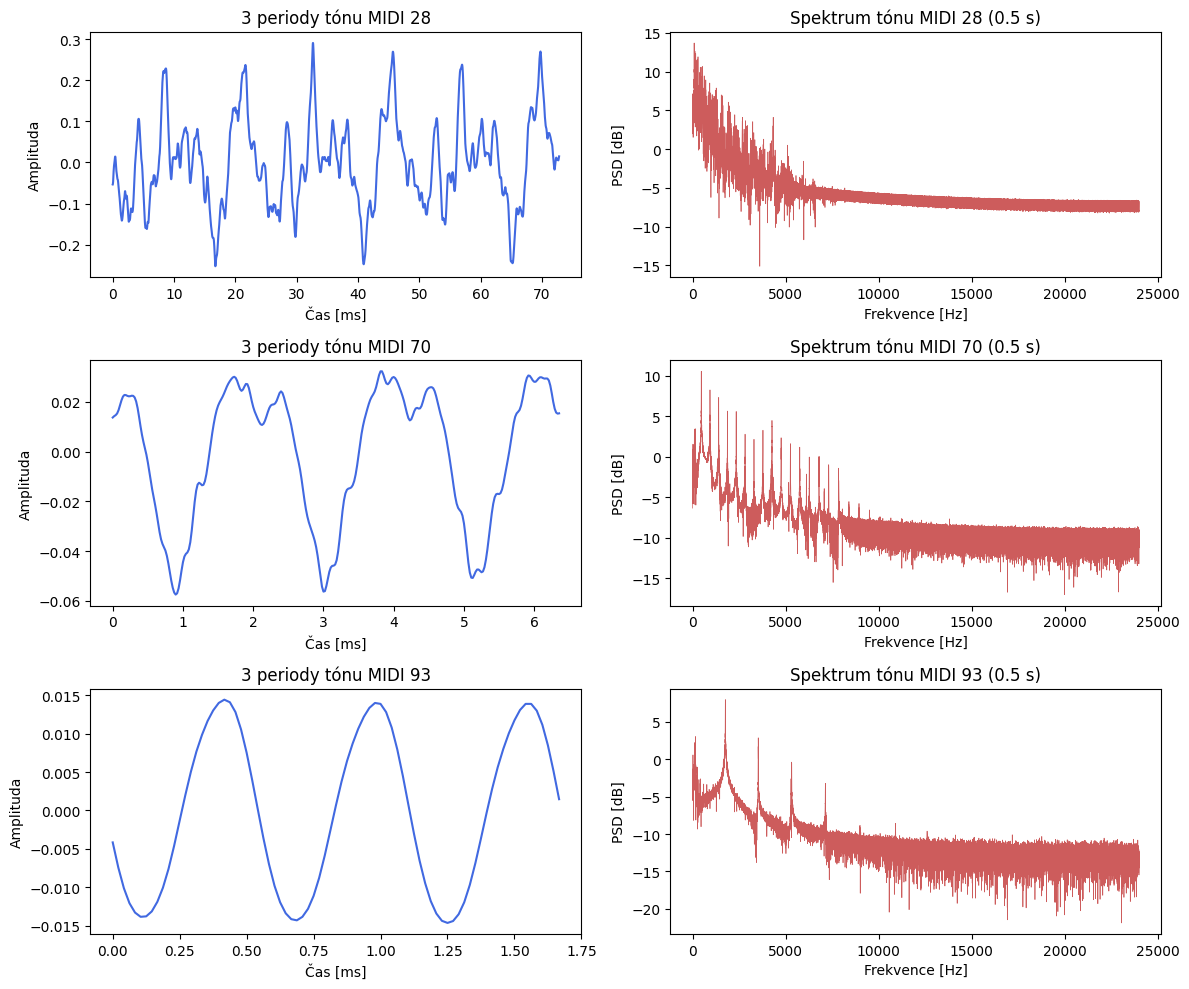

In [3]:
# F_s is sampling frequency of original_signal
# original_signal is array of floats
original_signal, F_s = sf.read('klavir.wav')

F_s # sampling frequency
T_s = 1/F_s # sampling period

tone_length = F_s*2 # length of one tone in number of samples = 2 seconds
length = len(original_signal) # length of original_signal in number of samples

# get half second of each tone
tones = {}


# load all notes (array is empty from 0 to 23)
# but we can index array by MIDI tone
for i in range(midi_low, midi_high+1):
    # get start and end of 0.5 s of tone in samples
    tone_start = (i-midi_low)*tone_length + tone_length//8
    tone_end = tone_start + tone_length//4
    
    # tones contains 0.5 s of each tone
    tones[i] = original_signal[tone_start:tone_end]

fig = plt.figure(figsize=(12, 10))

i = 0
for tone in my_tones:
    my_tone = tones[tone]    
    # save to file
    file_name = "audio/" + chr(i+97) + "_orig.wav"
    sf.write(file_name, my_tone, F_s)
    
    # plot 3 periods of tone
    # calculate length of one period in tone
    period = int(F_s/midi_freqs[tone])
    
    graph = fig.add_subplot(3, 2, (2*i)+1)
    graph.set_title("3 periody tónu MIDI " + str(tone))
    graph.set_xlabel("Čas [ms]")
    graph.set_ylabel("Amplituda")
    
    # x-axis is time in miliseconds (range from 0 to 3 periods)
    graph_range = np.arange(0,(3*period/F_s*1000),step=1/F_s*1000)
    graph.plot(graph_range, my_tone[:3*period], color='royalblue')
    
    # plot spectrum of tone
    dft = np.array(my_tone)
    # we are doing FFT on 0.5 s of tone, to get 24000 Hz spectrum we need to pad it to 1 second
    zero_padding = np.zeros(len(dft))
    dft = np.concatenate((dft, zero_padding))
    dft = np.fft.fft(dft)
    dft = np.abs(dft)

    graph = fig.add_subplot(3, 2, (2*i)+2)
    graph.set_title("Spektrum tónu MIDI " + str(tone) + " (0.5 s)")
    graph.set_xlabel("Frekvence [Hz]")
    graph.set_ylabel("PSD [dB]")
    
    log_psd = np.log(dft**2)[:F_s//2]
    graph.plot(log_psd + 10**-5, color='indianred', linewidth=0.5)
    i += 1
  
plt.tight_layout()  
plt.savefig("images/1_output.png")
plt.show()



In [4]:
# ----------- part 2 -------------

In [5]:
# calculate DFT and autocorrelation for each tone
# DFT fails for lower frequencies, but autocorrelation fails for higher frequencies
# we need to choose the one that is closer to the true frequency
dft = [0 for i in range(0, midi_high + 1)]
autocorrelation = [0 for i in range(0, midi_high + 1)]

for i in range(midi_low, midi_high+1):
    # calculate autocorrelation
    autocorrelation[i] = sp.signal.correlate(tones[i], tones[i], mode='full')
    autocorrelation[i] = autocorrelation[i][len(autocorrelation[i])//2:]
    # calculate DFT
    zero_padding = np.zeros(len(tones[i]))
    tones[i] = np.concatenate((tones[i], zero_padding))
    dft[i] = np.fft.fft(tones[i])

In [14]:
# source: 02_spectral.ipynb, thanks to Jan Cernocky

auto_freq = [0 for i in range(0, midi_high + 1)]
dft_freq  = [0 for i in range(0, midi_high + 1)]

for i in range(midi_low, midi_high + 1):
    auto_peaks, _ = sp.signal.find_peaks(autocorrelation[i], distance=F_s/40)
    auto_freq[i] = 1/auto_peaks[0]*F_s
    
    # get frequency from DFT, taken from 02_spectral.ipynb
    samples = len(dft[i])
    dft_range = np.arange(0,int(samples/2) +1)
    magnitudes = np.abs(dft[i][dft_range])
    freq = dft_range / samples * F_s
    dft_freq[i] = freq[np.argmax(magnitudes)]
        
    # print("MIDI tone " + str(i) + "\treal ", midi_freqs[i], "\tDFT " + str(dft_freq[i]))
    print("MIDI tone " + str(i) + "\treal ", midi_freqs[i], "\tautocorrelation " + str(auto_freq[i]) + "\tDFT " + str(dft_freq[i]))
    
    # plt.plot(autocorrelation[i][0:tone_length], color='indianred')
    # plt.plot(auto_peaks, autocorrelation[i][0:tone_length][auto_peaks], "x", color='royalblue')
    # plt.show()





MIDI tone 24	real  32.7 	autocorrelation 32.80929596719071	DFT 65.0
MIDI tone 25	real  34.65 	autocorrelation 34.757422157856624	DFT 69.0
MIDI tone 26	real  36.71 	autocorrelation 36.83806600153492	DFT 73.0
MIDI tone 27	real  38.89 	autocorrelation 39.02439024390244	DFT 78.0
MIDI tone 28	real  41.2 	autocorrelation 41.343669250645995	DFT 82.0
MIDI tone 29	real  43.65 	autocorrelation 43.7956204379562	DFT 87.0
MIDI tone 30	real  46.25 	autocorrelation 46.42166344294004	DFT 92.0
MIDI tone 31	real  49.0 	autocorrelation 49.18032786885246	DFT 97.99999999999999
MIDI tone 32	real  51.91 	autocorrelation 52.11726384364821	DFT 104.0
MIDI tone 33	real  55.0 	autocorrelation 55.172413793103445	DFT 110.0
MIDI tone 34	real  58.27 	autocorrelation 58.465286236297196	DFT 116.0
MIDI tone 35	real  61.74 	autocorrelation 61.935483870967744	DFT 123.0
MIDI tone 36	real  65.41 	autocorrelation 65.57377049180327	DFT 131.0
MIDI tone 37	real  69.3 	autocorrelation 69.46454413892909	DFT 138.0
MIDI tone 38	rea